### Fake News Classifier

In [ ]:
## 1. Data Collection and Preprocessing

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# Load data
data = pd.read_csv('WELFake_Dataset.csv')

# Drop unnecessary columns
data = data.drop(columns=['Unnamed: 0'])

# Display first few rows
print(data.head())

# Check for missing values
print(data.isnull().sum())

# Fill or drop missing values
data['title'].fillna('', inplace=True)
data.dropna(inplace=True)

# Preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['text'] = data['text'].apply(preprocess_text)
data['title'] = data['title'].apply(preprocess_text)

# Combine title and text for a more comprehensive feature
data['combined_text'] = data['title'] + " " + data['text']

# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['combined_text'], data['label'], test_size=0.2, random_state=42)


                                               title  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1                                                NaN   
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3  Bobby Jindal, raised Hindu, uses story of Chri...   
4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  
title    558
text      39
label      0
dtype: int64


### 2. Exploratory Data Analysis

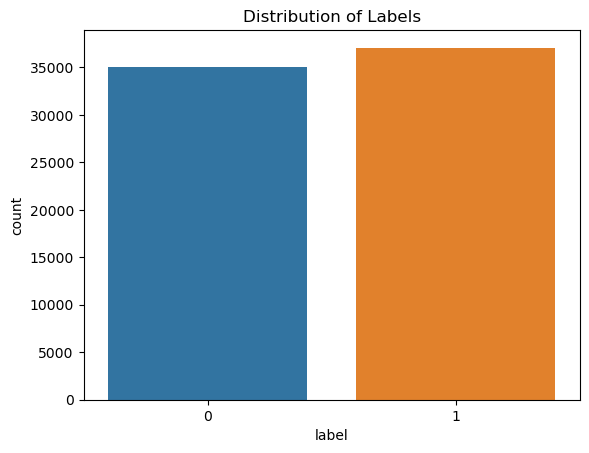

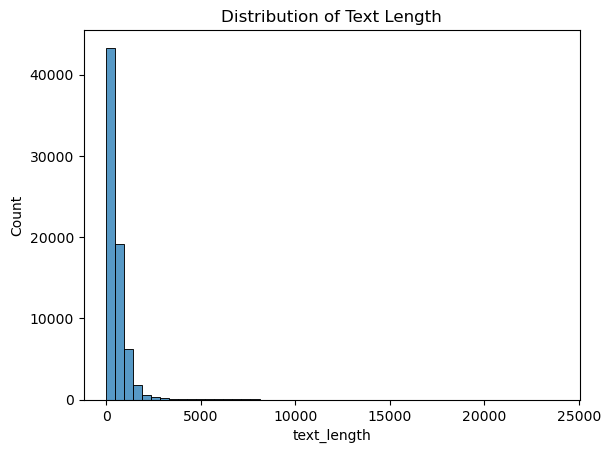

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of labels
sns.countplot(x='label', data=data)
plt.title('Distribution of Labels')
plt.show()

# Visualize the length of text
data['text_length'] = data['combined_text'].apply(lambda x: len(x.split()))
sns.histplot(data['text_length'], bins=50)
plt.title('Distribution of Text Length')
plt.show()


### 3. Feature Engineering and Model Development


In [6]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = 100
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

# Baseline model using RNN (LSTM)
baseline_model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_length),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
baseline_model.summary()

# Train the model
history = baseline_model.fit(X_train_padded, y_train, epochs=10, validation_split=0.2, batch_size=32)

# Evaluate the model
y_pred = (baseline_model.predict(X_test_padded) > 0.5).astype("int32")
from sklearn.metrics import f1_score
print(f"F1 Score: {f1_score(y_test, y_pred)}")


C:\Users\Priya Milton\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 173s 114ms/step - accuracy: 0.8568 - loss: 0.3279 - val_accuracy: 0.8935 - val_loss: 0.3229
Epoch 2/10
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 278s 167ms/step - accuracy: 0.9180 - loss: 0.2475 - val_accuracy: 0.9318 - val_loss: 0.2264
Epoch 3/10
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 858s 596ms/step - accuracy: 0.9327 - loss: 0.1926 - val_accuracy: 0.6237 - val_loss: 0.6190
Epoch 4/10
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 166s 115ms/step - accuracy: 0.9228 - loss: 0.2248 - val_accuracy: 0.9518 - val_loss: 0.1381
Epoch 5/10
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 164s 113ms/step - accuracy: 0.9495 - loss: 0.1434 - val_accuracy: 0.9535 - val_loss: 0.1307
Epoch 6/10
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 165s 114ms/step - accuracy: 0.9638 - loss: 0.1039 - val_accuracy: 0.9450 - val_loss: 0.1341
Epoch 7/10
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 165s 114ms/step - accuracy: 0.9613 - loss: 0.1044 - val_accuracy: 0.9577 - val_loss: 0.1114
Epoch 8/10
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 171s 119ms/step - ac

In [ ]:
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

def build_model(hp):
    model = Sequential()
    
    model.add(Embedding(input_dim=5000, output_dim=hp.Int('embedding_dim', min_value=32, max_value=128, step=32), input_length=max_length))
    
    for i in range(hp.Int('num_layers', 1, 3)):  # Number of LSTM layers
        model.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=True if i < hp.Int('num_layers', 1, 3) - 1 else False))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

